In [25]:
import networkx as nx
import datetime
from scipy.stats import norm
import numpy as np
import statistics
import pickle
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
german_levels = ['a1', 'a2', 'b1', 'b2', 'c1', 'c2', 'beginner', 'intermediate', 'advanced', 'native']

In [3]:
hierarchy = {
    'beginner': 0,
    'intermediate': 1,
    'advanced': 2,
    'native': 3
}

## Buscando os dados do subreddit

In [4]:
g = nx.read_gpickle('../y_data/threads/nx_german_tree')

In [5]:
users = {}

In [6]:
for item in g.nodes():
    if 'author' in g.node[item] and g.node[item]['author_flair']:
        for lb in german_levels:
            label = None
            if lb in g.node[item]['author_flair'].lower():
                label = lb
                break

        if label == 'a1' or label == 'a2' or label == 'beginner':
            label = 'beginner'
        elif label == 'b1' or label == 'b2' or label == 'intermediate':
            label = 'intermediate'
        elif label == 'c1' or label == 'c2' or label == 'advanced':
            label = 'advanced'
        else:
            label = label

        if label:
            if g.node[item]['author'] in users:
                users[g.node[item]['author']][g.node[item]['date']] = (label, item.strip('u').strip('\''))
            else:
                users[g.node[item]['author']] = {}
                users[g.node[item]['author']][g.node[item]['date']] = (label, item.strip('u').strip('\''))

## Buscando os resultados do método de ML

In [7]:
probs = {}
method = 'xg_boost'
file = open('../e_ml_methods/' + method + '.csv')
for line in file.readlines():
    id, correct, prob = line.split(',')
    probs[id.strip(' ')] = [float(i) for i in prob.strip(' [').strip(']\n').split()]

A variável `sequences` é um dicionário cujas chaves são os usuários e os valores estão em uma lista de listas. 

Essa lista é composta por listas pelas proficiências reais de todos os posts do usuário, em sequência, e três vetores de proficiência: cada um inclui a probabilidade de cada post apresentar aquele nível de proficiência (0, 1 ou 2).

Exemplo, para o usuário `MrGMann13`, que apresenta 2 publicações, tem como valores da tupla:

Proficiencia real: [0, 0]

Probabilidades: [[0.6758515, 0.30142012], [0.2036512, 0.38559732], [0.12049726, 0.3129826]]

O que representa:

|            	| Post 1     	| Post 2     	|
|------------	|------------	|------------	|
| Valor real 	| 0          	| 0          	|
| Prob(=0)   	| 0.6758515  	| 0.30142012 	|
| Prob(=1)   	| 0.2036512  	| 0.38559732 	|
| Prob(=2)   	| 0.12049726 	| 0.3129826  	|

A próxima célula é responsável por criar esta variável.

In [8]:
sequences = {}
for user in users:

    profs = []

    beg = []
    inte = []
    adv = []
    probabilities = [beg, inte, adv]

    l = users[user].keys()
    before = None

    seq = True
    for item in sorted(l):

        profs.append(hierarchy[users[user][item][0]])

        if str(users[user][item][1]) in probs:

            beg.append(probs[str(users[user][item][1])][0])
            inte.append(probs[str(users[user][item][1])][1])
            adv.append(probs[str(users[user][item][1])][2])
        else:
            seq = False

        if before == None:
            before = item
        else:
            if hierarchy[users[user][item][0]] < hierarchy[users[user][before][0]]:
                seq = False

        if not seq:
            break

    if seq and len(profs) > 1 and 3 not in profs:
        sequences[user] = (profs, probabilities)

Nota: fiz um teste (à mão mesmo!!!) pra conferir e os dois métodos possuem o mesmo vetor de sequencias (mesmos usuários, mesmos posts), só mudam as probabilidades (métodos diferentes, probabilidades diferentes!). 

(rodei o método duas vezes e salvei a coluna de probabilidades reais em duas variaveis diferentes, e depois comparei ambas)

## Inicializando o HMM-like

In [18]:
values = {0:0, 1:0, 2:0}
corretos = []
c=0
t=0
sequencias_possiveis = ['0', '1', '2', '01', '02', '12', '012']
real = {}
predito = {}
porc_pred = {}
mean_p = {}
for seq in sequencias_possiveis:
    real[seq] = 0
    predito[seq] = 0
    porc_pred[seq] = []
    mean_p[seq] = []
f1_g = []
f1_t = []

zero_to_one_real = []
one_to_two_real = []
zero_to_two_real = []

zero_to_one_calc = []
one_to_two_calc = []
zero_to_two_calc = []

confusion = [[0 for m in range(4)] for n in range(4)] 

In [23]:
# para cada usuário
for user in sequences:
    # salvo as proficiências reais dele
    proficiencias = sequences[user][0]
    f1_t = f1_t + proficiencias
    # N = número de posts
    N = len(proficiencias)
    
    log_prob = np.asarray(sequences[user][1])

    sum_to_end = np.cumsum(log_prob[:,::-1],1)[:,::-1]

    R = log_prob.copy()
    first_change = np.ones(2)*N
    R[2,:] = np.cumsum(log_prob[2,::-1])[::-1]

    
    # aplicação do método
    for j in range(1,-1,-1):
        for i in range(N-1,-1,-1):
            rew_stay = log_prob[j,i]+R[j,i+1] if i < N-1 else log_prob[j,i]
            R[j,i] = max(rew_stay,R[j+1,i])
            if rew_stay < R[j+1,i]:
                first_change[j] = min(first_change[j],i)
                
    lista = []
    if int(first_change[1]) >= int(first_change[0]):
        for i in range(0, int(first_change[0])):
            lista.append(0)
        for i in range(int(first_change[0]), int(first_change[1])):
            lista.append(1)
        for i in range(int(first_change[1]), len(proficiencias)):
            lista.append(2)
    else:
        for i in range(0, int(first_change[1])):
            lista.append(0)
        for i in range(int(first_change[1]), len(proficiencias)):
            lista.append(2)

    key = None
    if 0 in proficiencias and 1 not in proficiencias and 2 not in proficiencias:
        real['0'] = real['0'] + 1
        key = '0'
    elif 0 not in proficiencias and 1 in proficiencias and 2 not in proficiencias:
        real['1'] = real['1'] + 1
        key = '1'
    elif 0 not in proficiencias and 1 not in proficiencias and 2 in proficiencias:
        real['2'] = real['2'] + 1
        key = '2'
    elif 0 in proficiencias and 1 in proficiencias and 2 not in proficiencias:
        real['01'] = real['01'] + 1
        key = '01'
    elif 0 in proficiencias and 1 not in proficiencias and 2 in proficiencias:
        real['02'] = real['02'] + 1
        key = '02'
    elif 0 not in proficiencias and 1 in proficiencias and 2 in proficiencias:
        real['12'] = real['12'] + 1
        key = '12'
    elif 0 in proficiencias and 1 in proficiencias and 2 in proficiencias:
        real['012'] = real['012'] + 1
        key = '012'

    if 0 in lista and 1 not in lista and 2 not in lista:
        predito['0'] = predito['0'] + 1
    elif 0 not in lista and 1 in lista and 2 not in lista:
        predito['1'] = predito['1'] + 1
    elif 0 not in lista and 1 not in lista and 2 in lista:
        predito['2'] = predito['2'] + 1
    elif 0 in lista and 1 in lista and 2 not in lista:
        predito['01'] = predito['01'] + 1	
    elif 0 in lista and 1 not in lista and 2 in lista:
        predito['02'] = predito['02'] + 1
    elif 0 not in lista and 1 in lista and 2 in lista:
        predito['12'] = predito['12'] + 1
    elif 0 in lista and 1 in lista and 2 in lista:
        predito['012'] = predito['012'] + 1

    certos = 0
    total = 0
    f1_g = f1_g + lista
    
    pl = [i for i,x in enumerate(np.diff(proficiencias)) if x == 1]
    if len(pl) > 1:
        zero_to_one_real.append(pl[0])
        one_to_two_real.append(pl[1])
    elif len(pl) > 0:
        zero_to_one_real.append(pl[0])
        
    pl = [i for i,x in enumerate(np.diff(lista)) if x == 1]
    if len(pl) > 1:
        zero_to_one_calc.append(pl[0])
        one_to_two_calc.append(pl[1])
    elif len(pl) > 0:
        zero_to_one_calc.append(pl[0])
        
    for i in range(0, len(lista)):
        confusion[proficiencias[i]][lista[i]] = confusion[proficiencias[i]][lista[i]] + 1
        if proficiencias[i] == lista[i]:
            certos = certos + 1
            c=c+1
        total = total + 1
        t=t+1
        values[proficiencias[i]] = values[proficiencias[i]] + 1
    corretos.append((float(certos)/float(total))*100)
    porc_pred[key].append(float(certos)/float(total))
    mean_p[key].append(len(user))

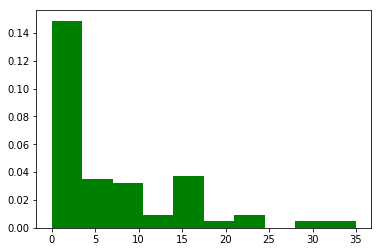

In [33]:
plt.hist(zero_to_one_real, density=True, facecolor='g')
plt.show()

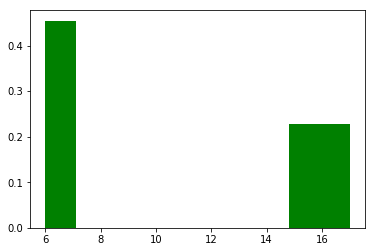

In [35]:
plt.hist(one_to_two_real, density=True, facecolor='g')
plt.show()

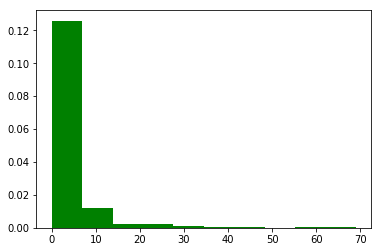

In [32]:
plt.hist(zero_to_one_calc, density=True, facecolor='g')
plt.show()

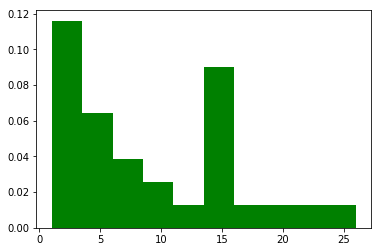

In [34]:
plt.hist(one_to_two_calc, density=True, facecolor='g')
#plt.xlabel('Smarts')
#plt.ylabel('Probability')
#plt.title('Histogram of IQ')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
#plt.axis([40, 160, 0, 0.03])
#plt.grid(True)
plt.show()

In [19]:
print method
print 'media de acertos por usuário:', statistics.mean(corretos)
print 'porcentagem de acertos totais:', "{0:.2f}".format((float(c)/float(t))*100)
print 'total de posts:', t
print 'classificação dos posts: ', values
print 'sequencias reais: ', real
print 'sequencias preditas: ', predito
print '\nPorcentagem de acertos por grupo de usuarios: '
for key in porc_pred:
    print key, statistics.mean(porc_pred[key])

print '\nMedia de posts por usuario: '
for key in mean_p:
    print key, statistics.mean(mean_p[key])
    
print 'f1: ', f1_score(f1_t, f1_g, average='weighted')
print confusion

xg_boost
media de acertos por usuário: 57.2278137256
porcentagem de acertos totais: 59.44
total de posts: 9099
classificação dos posts:  {0: 3973, 1: 3763, 2: 1363}
sequencias reais:  {'02': 3, '12': 16, '01': 43, '1': 417, '0': 606, '012': 2, '2': 132}
sequencias preditas:  {'02': 17, '12': 82, '01': 342, '1': 572, '0': 148, '012': 31, '2': 27}

Porcentagem de acertos por grupo de usuarios: 
02 0.2
12 0.565461309657
01 0.652450737259
1 0.878633191288
0 0.434344650219
012 0.686991869919
2 0.219147000899

Media de posts por usuario: 
02 13.6666666667
12 10.8125
01 9.81395348837
1 10.7170263789
0 10.6254125413
012 8.5
2 10.8181818182
f1:  0.5647151202445577
[[1619, 2271, 83, 0], [161, 3502, 100, 0], [55, 1021, 287, 0], [0, 0, 0, 0]]


In [20]:
{'02': 3, '12': 16, '01': 43, '1': 417, '0': 606, '012': 2, '2': 132}
{'02': 3, '12': 16, '01': 43, '1': 417, '0': 606, '012': 2, '2': 132}

{'0': 606, '01': 43, '012': 2, '02': 3, '1': 417, '12': 16, '2': 132}

In [ ]:
{'02': 17, '12': 82, '01': 342, '1': 572, '0': 148, '012': 31, '2': 27}
{'02': 22, '12': 81, '01': 342, '1': 535, '0': 176, '012': 35, '2': 28}